In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime, timedelta
np.random.seed(42)

In [74]:
customers = pd.DataFrame({
    'customer_id': range(1, 101),
    'name': [f'Customer_{i}' for i in range(1, 101)]
})

In [75]:
products = pd.DataFrame({
    'product_id': range(1, 51),
    'category': np.random.choice(['LAPTOPS', 'SMARTPHONES', 'TABLETS', 'GAMING_CONSOLES', 'ACCESSORIES','OTHERS'], 50),
    'price': np.random.uniform(10, 200, 50).round(2),
    'brand': np.random.choice(['HP', 'DELL', 'APPLE', 'SAMSUNG', 'MICROSOFT'], 50),
    'product_name': [f'Product_{i}' for i in range(1, 51)]
})

In [76]:
n_interactions = 500
interaction_data = []

In [77]:
for _ in range(n_interactions):
    customer_id = np.random.choice(customers['customer_id'])
    product_id = np.random.choice(products['product_id'])
    quantity = np.random.randint(1, 20)
    order_frequency = np.random.randint(1, 5)
    days_ago = np.random.randint(1, 1825)
    last_purchase = datetime.now() - timedelta(days=days_ago)

    interaction_data.append({
        'customer_id': customer_id,
        'product_id': product_id,
        'quantity': quantity,
        'order_frequency': order_frequency,
        'last_purchase': last_purchase,
        'days_since_purchase': days_ago
    })

interactions_df = pd.DataFrame(interaction_data)

In [78]:
interactions_df = interactions_df.merge(products, on='product_id')

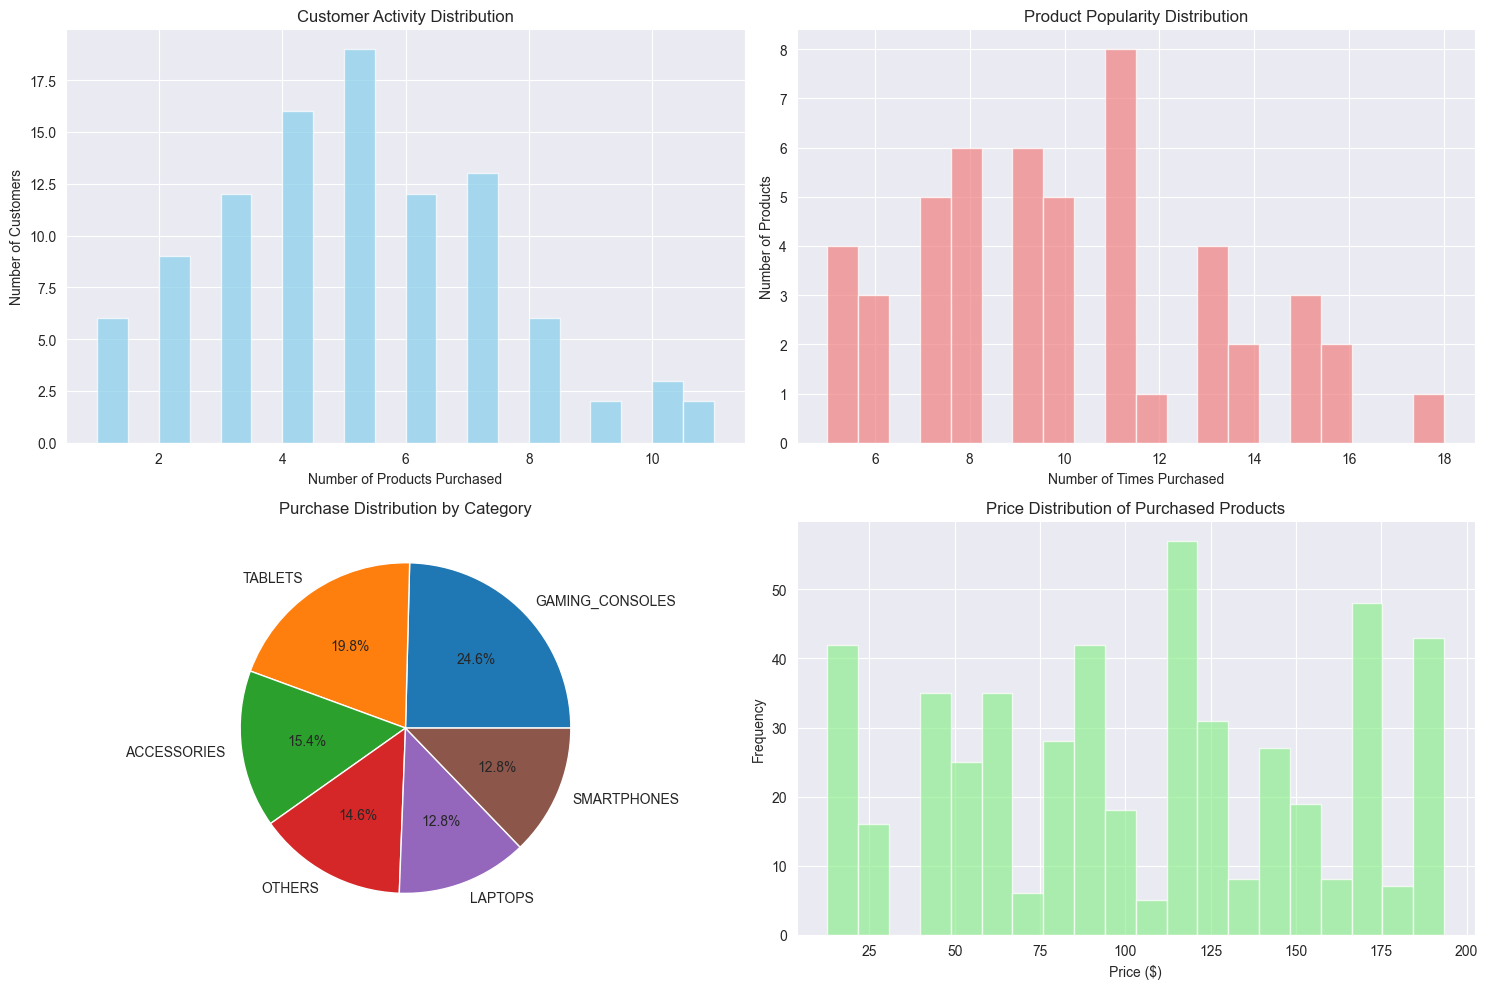

In [79]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

customer_activity = interactions_df['customer_id'].value_counts()
axes[0,0].hist(customer_activity.values, bins=20, alpha=0.7, color='skyblue')
axes[0,0].set_title('Customer Activity Distribution')
axes[0,0].set_xlabel('Number of Products Purchased')
axes[0,0].set_ylabel('Number of Customers')

product_popularity = interactions_df['product_id'].value_counts()
axes[0,1].hist(product_popularity.values, bins=20, alpha=0.7, color='lightcoral')
axes[0,1].set_title('Product Popularity Distribution')
axes[0,1].set_xlabel('Number of Times Purchased')
axes[0,1].set_ylabel('Number of Products')

category_counts = interactions_df['category'].value_counts()
axes[1,0].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
axes[1,0].set_title('Purchase Distribution by Category')

axes[1,1].hist(interactions_df['price'], bins=20, alpha=0.7, color='lightgreen')
axes[1,1].set_title('Price Distribution of Purchased Products')
axes[1,1].set_xlabel('Price ($)')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [80]:
interactions_df['recency_weight'] = np.exp(-interactions_df['days_since_purchase'] / 365)

In [81]:
interactions_df['interaction_score'] = (
    interactions_df['quantity'] *
    interactions_df['order_frequency'] *
    interactions_df['recency_weight']
)

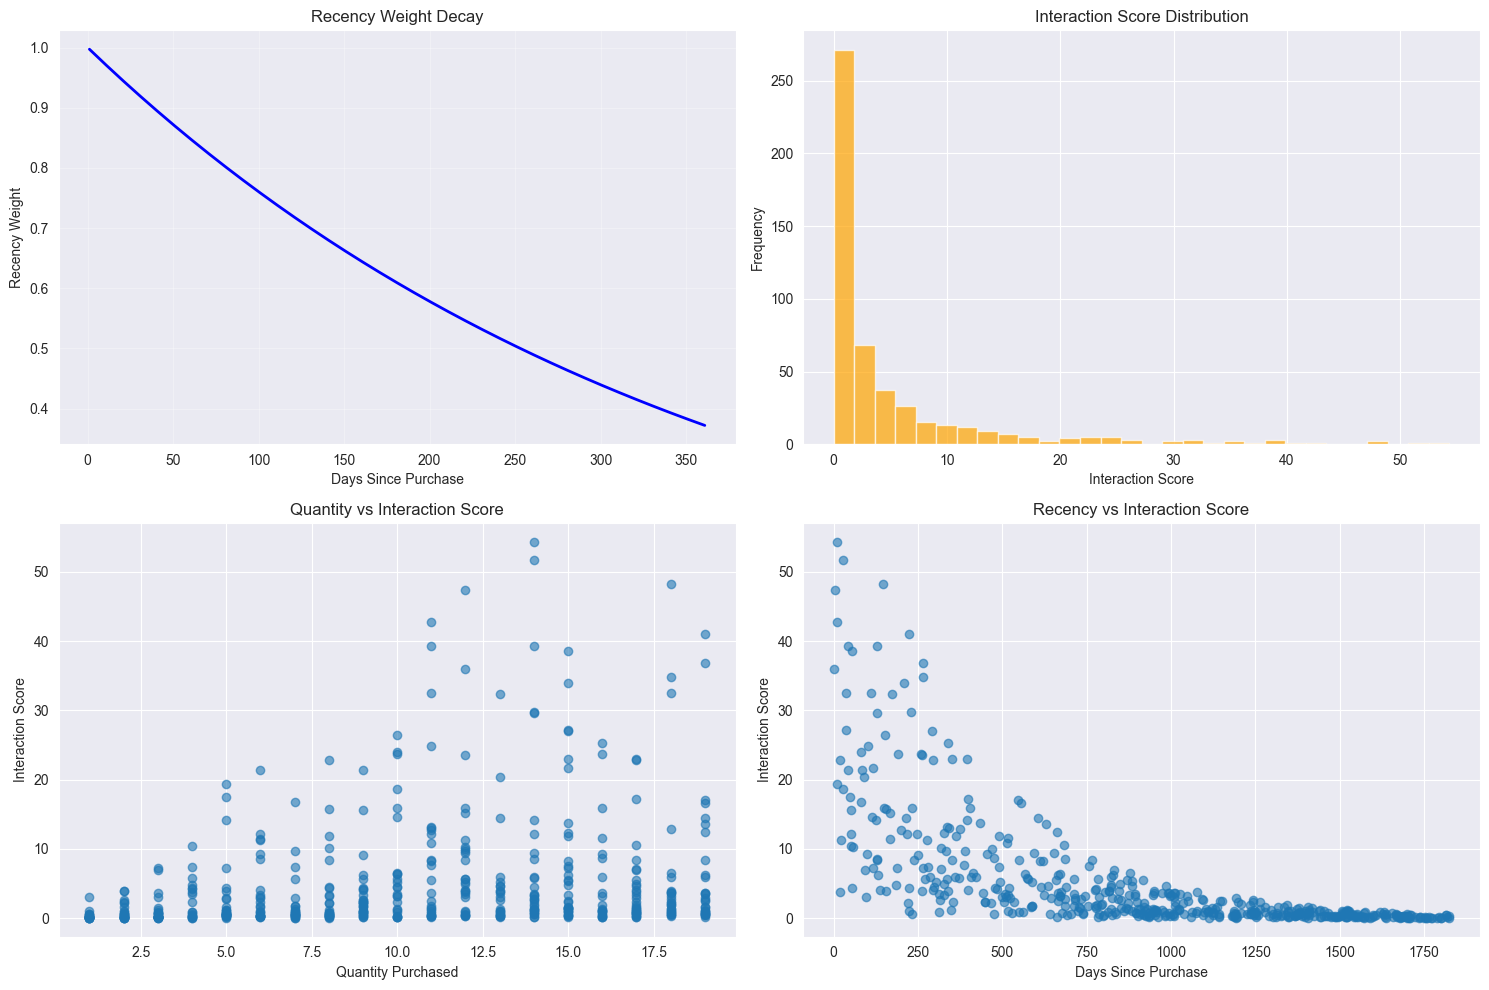

In [82]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

days_range = np.arange(1, 365, 10)
recency_weights = np.exp(-days_range / 365)
axes[0,0].plot(days_range, recency_weights, 'b-', linewidth=2)
axes[0,0].set_title('Recency Weight Decay')
axes[0,0].set_xlabel('Days Since Purchase')
axes[0,0].set_ylabel('Recency Weight')
axes[0,0].grid(True, alpha=0.3)

axes[0,1].hist(interactions_df['interaction_score'], bins=30, alpha=0.7, color='orange')
axes[0,1].set_title('Interaction Score Distribution')
axes[0,1].set_xlabel('Interaction Score')
axes[0,1].set_ylabel('Frequency')

axes[1,0].scatter(interactions_df['quantity'], interactions_df['interaction_score'], alpha=0.6)
axes[1,0].set_title('Quantity vs Interaction Score')
axes[1,0].set_xlabel('Quantity Purchased')
axes[1,0].set_ylabel('Interaction Score')

axes[1,1].scatter(interactions_df['days_since_purchase'], interactions_df['interaction_score'], alpha=0.6)
axes[1,1].set_title('Recency vs Interaction Score')
axes[1,1].set_xlabel('Days Since Purchase')
axes[1,1].set_ylabel('Interaction Score')

plt.tight_layout()
plt.show()

In [83]:
def create_user_item_matrix(interactions_df):
    user_item_matrix = interactions_df.pivot_table(
        index='customer_id',
        columns='product_id',
        values='interaction_score',
        fill_value=0
    )
    return user_item_matrix

user_item_matrix = create_user_item_matrix(interactions_df)

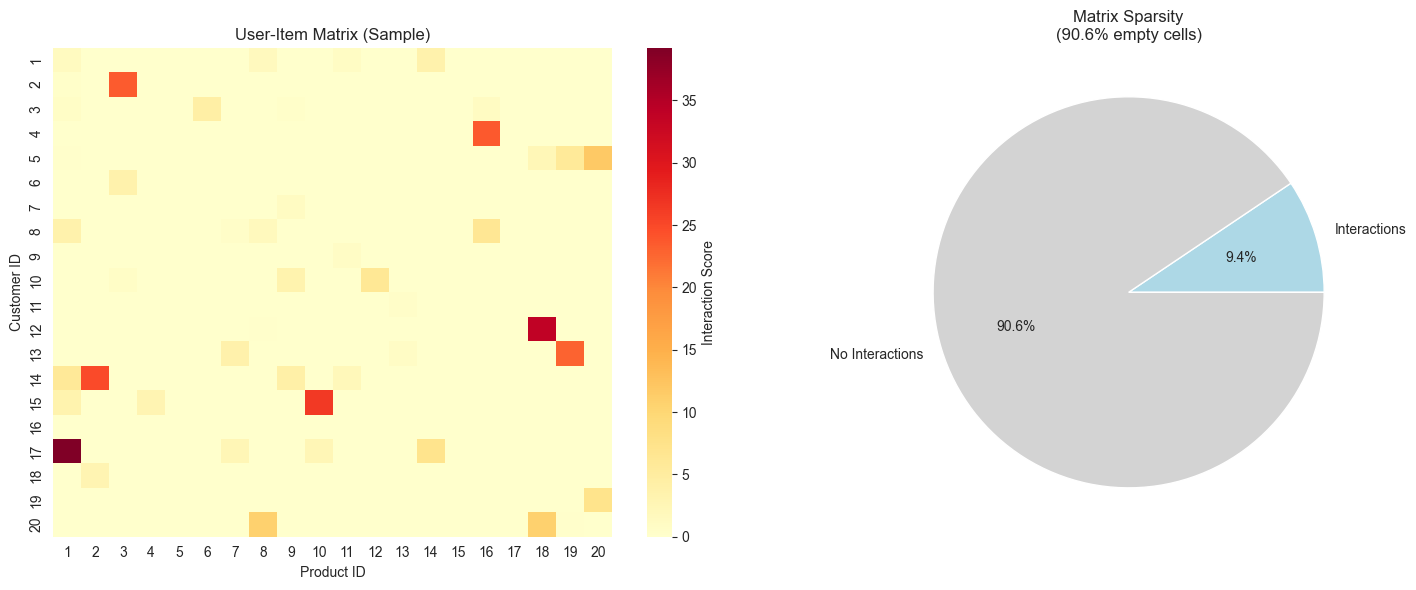

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

subset = user_item_matrix.iloc[:20, :20]
sns.heatmap(subset, cmap='YlOrRd', ax=axes[0], cbar_kws={'label': 'Interaction Score'})
axes[0].set_title('User-Item Matrix (Sample)')
axes[0].set_xlabel('Product ID')
axes[0].set_ylabel('Customer ID')

sparsity = (user_item_matrix == 0).sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1])
filled = 1 - sparsity

axes[1].pie([filled, sparsity], labels=['Interactions', 'No Interactions'],
            autopct='%1.1f%%', colors=['lightblue', 'lightgray'])
axes[1].set_title(f'Matrix Sparsity\n({sparsity:.1%} empty cells)')

plt.tight_layout()
plt.show()

In [85]:
def find_similar_customers(user_item_matrix, target_customer, num_neighbors=10):
    if target_customer not in user_item_matrix.index:
        return []

    target_vector = user_item_matrix.loc[target_customer].values.reshape(1, -1)
    similarities = cosine_similarity(target_vector, user_item_matrix.values)[0]

    customer_similarities = [
        (customer_id, similarity)
        for customer_id, similarity in zip(user_item_matrix.index, similarities)
        if customer_id != target_customer and similarity > 0.1
    ]

    return sorted(customer_similarities, key=lambda x: x[1], reverse=True)[:num_neighbors]


In [86]:
target_customer = 1
similar_customers = find_similar_customers(user_item_matrix, target_customer, num_neighbors=15)

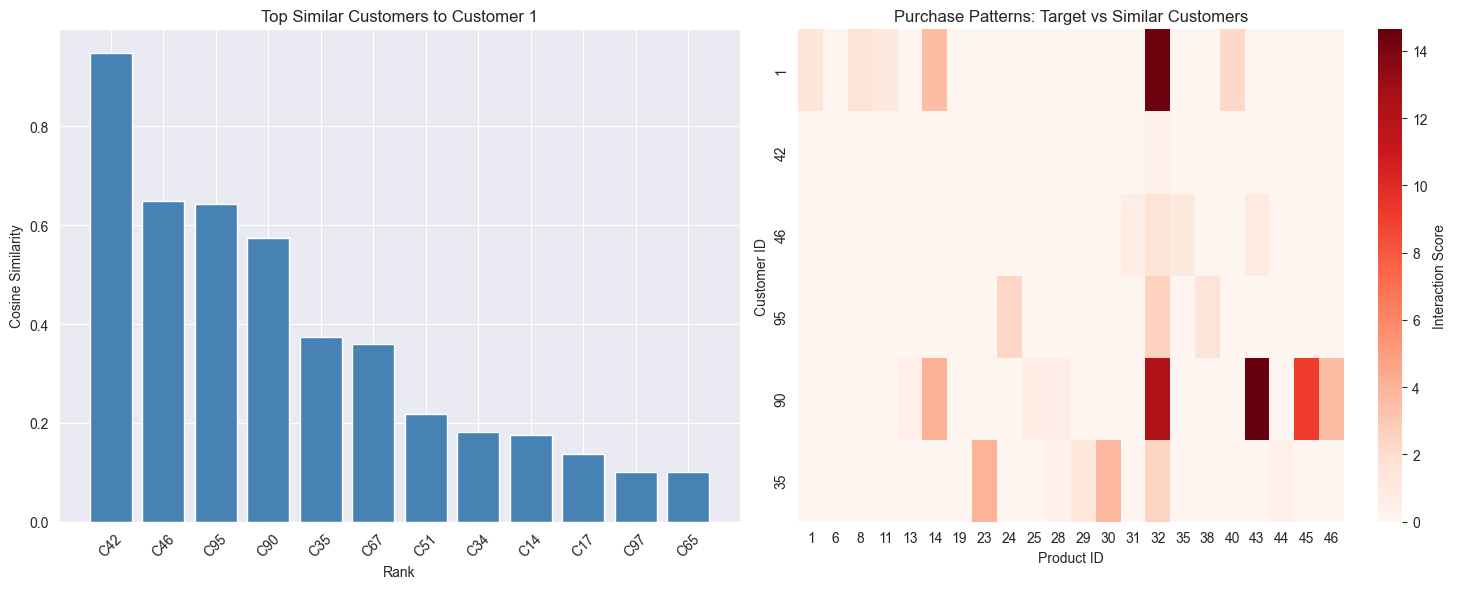

 Found 12 similar customers to Customer 1
   Top 3 most similar:
   1. Customer 42: 0.949 similarity
   2. Customer 46: 0.649 similarity
   3. Customer 95: 0.644 similarity


In [87]:
if similar_customers:
    similarity_df = pd.DataFrame(similar_customers, columns=['Customer_ID', 'Similarity'])

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    axes[0].bar(range(len(similarity_df)), similarity_df['Similarity'], color='steelblue')
    axes[0].set_title(f'Top Similar Customers to Customer {target_customer}')
    axes[0].set_xlabel('Rank')
    axes[0].set_ylabel('Cosine Similarity')
    axes[0].set_xticks(range(len(similarity_df)))
    axes[0].set_xticklabels([f'C{int(cid)}' for cid in similarity_df['Customer_ID']], rotation=45)

    customer_ids = [target_customer] + [int(cid) for cid, _ in similar_customers[:5]]
    purchase_patterns = user_item_matrix.loc[customer_ids]

    active_products = (purchase_patterns > 0).any(axis=0)
    purchase_patterns_filtered = purchase_patterns.loc[:, active_products]

    if not purchase_patterns_filtered.empty:
        sns.heatmap(purchase_patterns_filtered, cmap='Reds', axes=axes[1],
                   cbar_kws={'label': 'Interaction Score'})
        axes[1].set_title('Purchase Patterns: Target vs Similar Customers')
        axes[1].set_xlabel('Product ID')
        axes[1].set_ylabel('Customer ID')

    plt.tight_layout()
    plt.show()

    print(f" Found {len(similar_customers)} similar customers to Customer {target_customer}")
    print(f"   Top 3 most similar:")
    for i, (cust_id, sim) in enumerate(similar_customers[:3]):
        print(f"   {i+1}. Customer {cust_id}: {sim:.3f} similarity")
else:
    print(f"No similar customers found for Customer {target_customer}")


In [88]:
def generate_recommendations(target_customer, similar_customers, interactions_df, user_item_matrix):


    purchased_products = set(
        interactions_df[interactions_df['customer_id'] == target_customer]['product_id']
    )

    recommendations = {}

    for similar_customer, similarity in similar_customers:
        similar_purchases = interactions_df[
            interactions_df['customer_id'] == similar_customer
        ]

        for _, product in similar_purchases.iterrows():
            product_id = product['product_id']


            if product_id in purchased_products:
                continue

            if product_id not in recommendations:
                recommendations[product_id] = {
                    'score': 0,
                    'category': product['category'],
                    'price': float(product['price']),
                    'brand': product['brand'],
                    'recommender_count': 0,
                    'product_name': product['product_name']
                }

            weighted_score = product['interaction_score'] * similarity
            recommendations[product_id]['score'] += weighted_score
            recommendations[product_id]['recommender_count'] += 1

    return recommendations

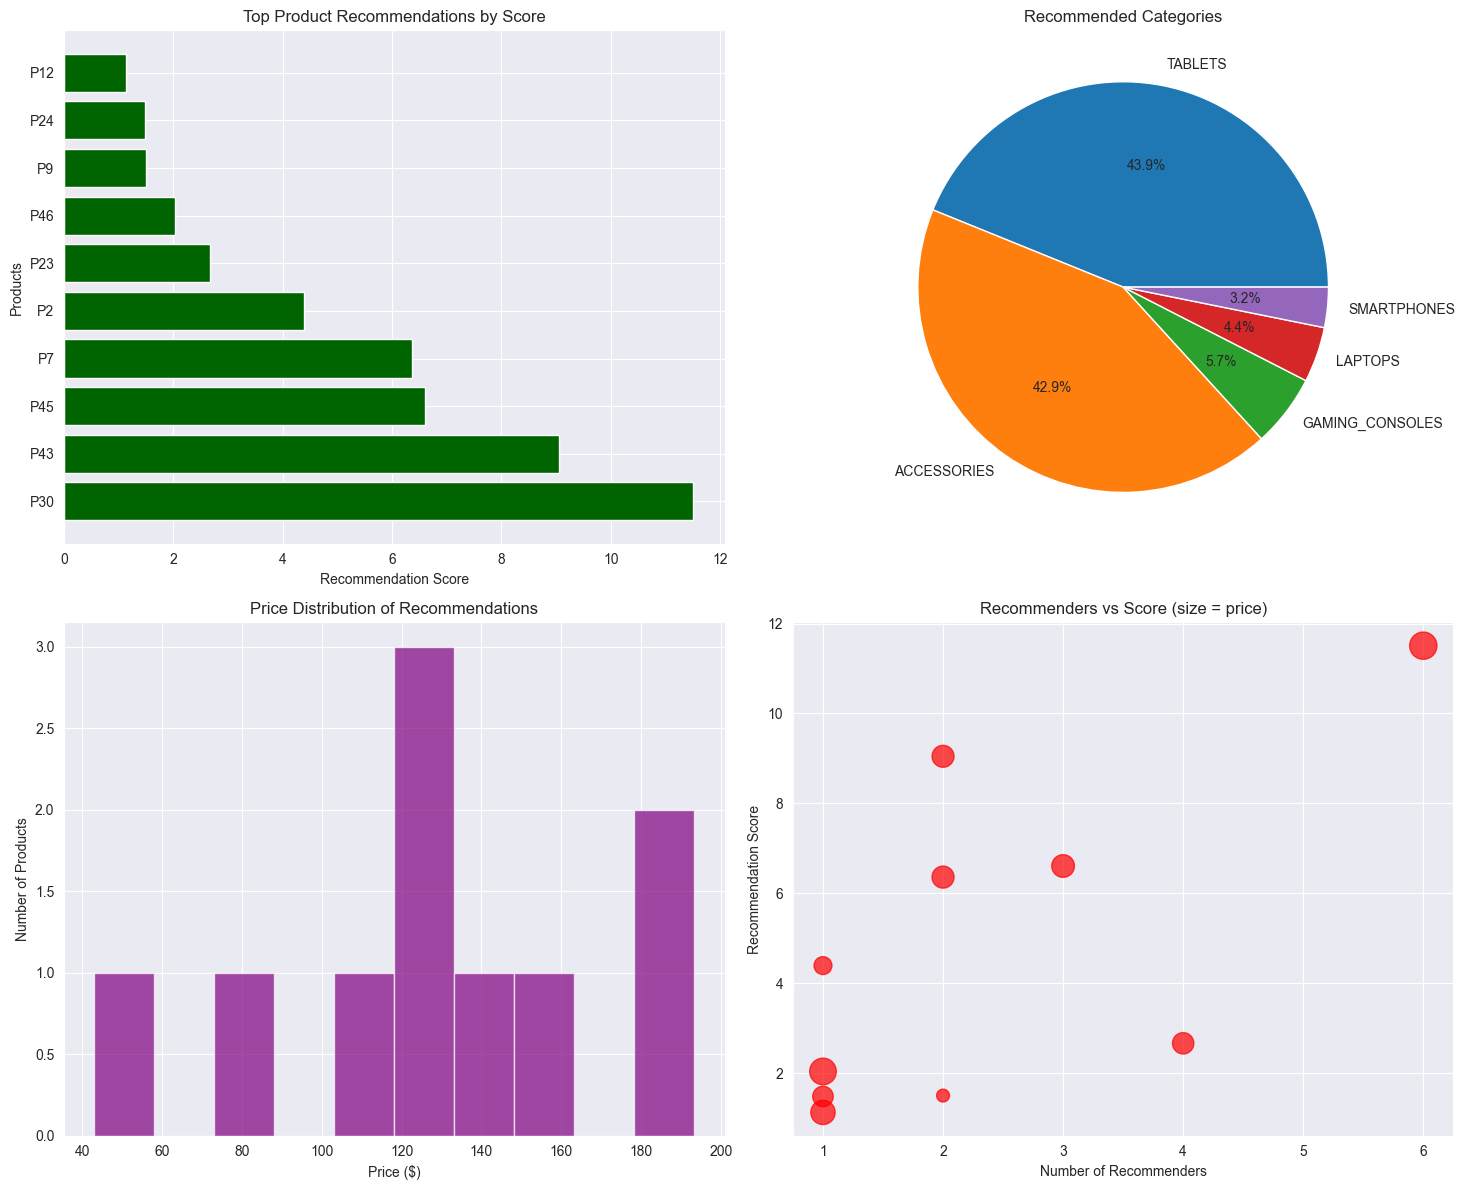

In [89]:
if similar_customers:
    recommendations = generate_recommendations(target_customer, similar_customers, interactions_df, user_item_matrix)

    if recommendations:
        rec_df = pd.DataFrame.from_dict(recommendations, orient='index')
        rec_df.index.name = 'Product_ID'
        rec_df = rec_df.sort_values('score', ascending=False).head(10)

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        axes[0,0].barh(range(len(rec_df)), rec_df['score'], color='darkgreen')
        axes[0,0].set_title('Top Product Recommendations by Score')
        axes[0,0].set_ylabel('Products')
        axes[0,0].set_xlabel('Recommendation Score')
        axes[0,0].set_yticks(range(len(rec_df)))
        axes[0,0].set_yticklabels([f'P{pid}' for pid in rec_df.index])

        category_scores = rec_df.groupby('category')['score'].sum().sort_values(ascending=False)
        axes[0,1].pie(category_scores.values, labels=category_scores.index, autopct='%1.1f%%')
        axes[0,1].set_title('Recommended Categories')

        axes[1,0].hist(rec_df['price'], bins=10, alpha=0.7, color='purple')
        axes[1,0].set_title('Price Distribution of Recommendations')
        axes[1,0].set_xlabel('Price ($)')
        axes[1,0].set_ylabel('Number of Products')

        axes[1,1].scatter(rec_df['recommender_count'], rec_df['score'],
                         s=rec_df['price']*2, alpha=0.7, color='red')
        axes[1,1].set_title('Recommenders vs Score (size = price)')
        axes[1,1].set_xlabel('Number of Recommenders')
        axes[1,1].set_ylabel('Recommendation Score')

        plt.tight_layout()
        plt.show()

In [90]:
def apply_business_filters(recommendations, target_customer, interactions_df):

    customer_data = interactions_df[interactions_df['customer_id'] == target_customer]
    avg_price = customer_data['price'].mean() if not customer_data.empty else 50.0
    purchased_categories = set(customer_data['category'].unique())

    filtered = {}
    category_counts = {}

    sorted_recs = sorted(recommendations.items(), key=lambda x: x[1]['score'], reverse=True)

    for product_id, rec_data in sorted_recs:
        category = rec_data['category']
        price = rec_data['price']


        if not (avg_price * 0.5 <= price <= avg_price * 2.0):
            continue

        category_counts.setdefault(category, 0)
        if category_counts[category] >= 3:
            continue

        if category not in purchased_categories:
            rec_data['score'] *= 1.2


        if rec_data['recommender_count'] >= 3:
            rec_data['score'] *= 1.1

        rec_data['score'] = float(rec_data['score'])

        filtered[product_id] = rec_data
        category_counts[category] += 1

        if len(filtered) >= 10:
            break

    return filtered

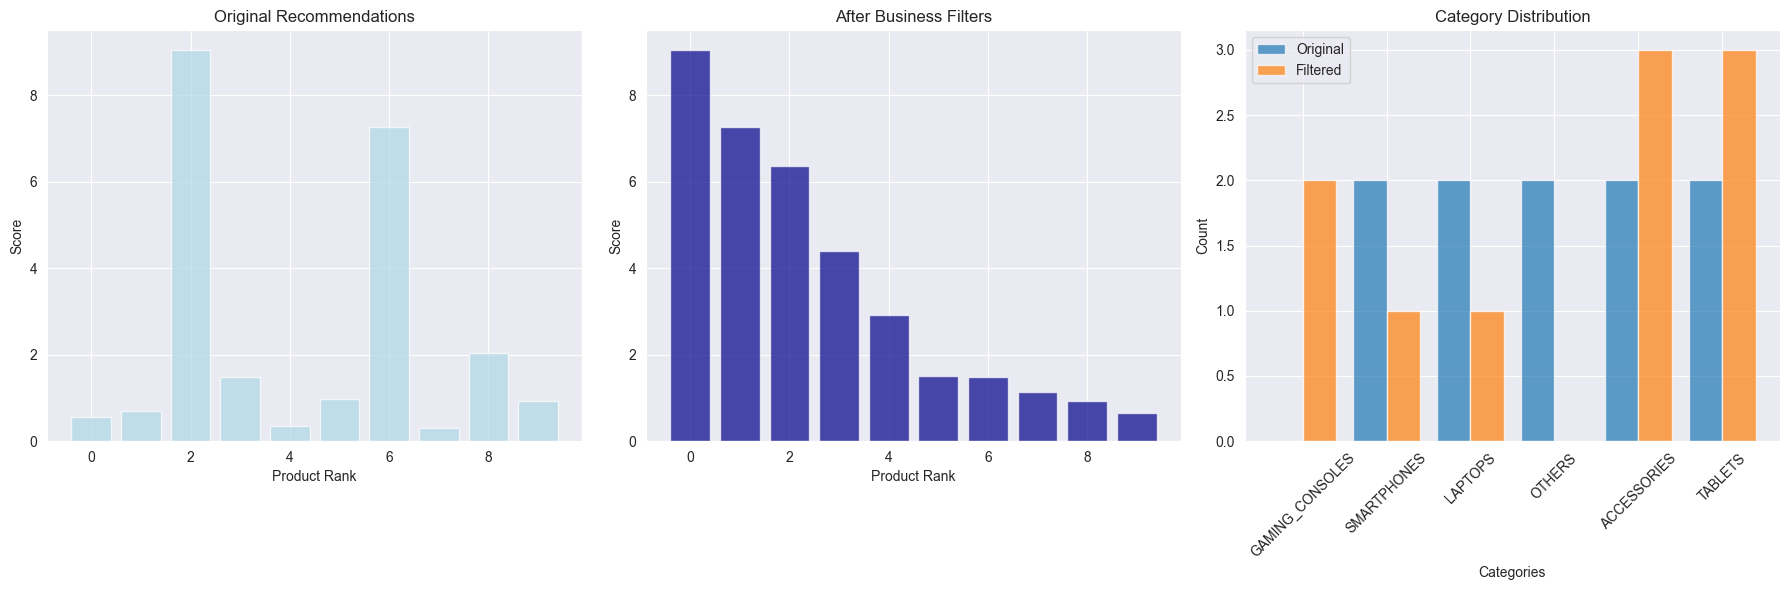

In [91]:
if 'recommendations' in locals() and recommendations:
    filtered_recommendations = apply_business_filters(recommendations, target_customer, interactions_df)

    if filtered_recommendations:

        original_df = pd.DataFrame.from_dict(recommendations, orient='index').head(10)
        filtered_df = pd.DataFrame.from_dict(filtered_recommendations, orient='index')

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        axes[0].bar(range(len(original_df)), original_df['score'], color='lightblue', alpha=0.7)
        axes[0].set_title('Original Recommendations')
        axes[0].set_xlabel('Product Rank')
        axes[0].set_ylabel('Score')

        axes[1].bar(range(len(filtered_df)), filtered_df['score'], color='darkblue', alpha=0.7)
        axes[1].set_title('After Business Filters')
        axes[1].set_xlabel('Product Rank')
        axes[1].set_ylabel('Score')

        orig_categories = original_df['category'].value_counts()
        filt_categories = filtered_df['category'].value_counts()

        categories = list(set(orig_categories.index) | set(filt_categories.index))
        orig_counts = [orig_categories.get(cat, 0) for cat in categories]
        filt_counts = [filt_categories.get(cat, 0) for cat in categories]

        x_pos = np.arange(len(categories))
        axes[2].bar(x_pos - 0.2, orig_counts, 0.4, label='Original', alpha=0.7)
        axes[2].bar(x_pos + 0.2, filt_counts, 0.4, label='Filtered', alpha=0.7)
        axes[2].set_title('Category Distribution')
        axes[2].set_xlabel('Categories')
        axes[2].set_ylabel('Count')
        axes[2].set_xticks(x_pos)
        axes[2].set_xticklabels(categories, rotation=45)
        axes[2].legend()

        plt.tight_layout()
        plt.show()

In [93]:
print(f"   - Original recommendations: {len(recommendations)}")
print(f"   - After filtering: {len(filtered_recommendations)}")
print('\n')
display_cols = ['product_name', 'category', 'price', 'score', 'recommender_count']
print(filtered_df[display_cols].head().to_string())

   - Original recommendations: 30
   - After filtering: 10


   product_name         category   price     score  recommender_count
43   Product_43      ACCESSORIES  125.13  9.047150                  2
45   Product_45      ACCESSORIES  133.70  7.267662                  3
7     Product_7          TABLETS  125.90  6.359877                  2
2     Product_2      ACCESSORIES   83.23  4.391507                  1
23   Product_23  GAMING_CONSOLES  118.38  2.929227                  4
